In [1]:
from Functions import *
import winsound

# Preliminary

In [2]:
def define_Telescope(E0, m1_p=185.0, m1_q=-58.0, m2_q=1e5):
    z_s = 650
    
    ## Telescope
    m1 = optics.CurvedMirror('M1', p=m1_p, q=m1_q, length=1, z=m1_p+z_s, alpha=2.65e-3)
    im_after_T1 = optics.PPM('im_after_T1', z=m1.z+.01, FOV=5e-3, N=512)
    
    # m2_p is longer than what it should be to create a slight defocusing effect
    m2 = optics.CurvedMirror('M2', p=300-m1_p-m1_q+2.0, q=m2_q, length=1, z=300+z_s, alpha=2.65e-3, orientation=2)
    im_after_T2 = optics.PPM('im_after_T2', z=m2.z+.01, FOV=5e-3, N=512)

    Telescope_devices = [m1, im_after_T1, m2, im_after_T2]

    return Telescope_devices

In [3]:
# regular beamline
def define_beamline_normal(
    E0, m1_p=185.0, m2_q=1e5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 0.0,
    hkl2 = [2,2,0], alphaAsym2 = 0.0,
    hkl3 = [5,5,5], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=512)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m1_q=-25.6, m2_q=m2_q)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)
    

    all_devices = [im_input] + Telescope_devices + HHLM_devices + HRM_devices
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline


### 1. common simulation parameters

In [4]:
''' Beam parameters '''
N = 1024          # number of sampling points
E0 = 17795        # photon energy [eV]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 650-26
}

##### common simulation parameters
m1_p = 185.0; m2_q = 1e5
f1 = 10.0; f2 = 10.0            # f1: crystal-mirror distance, f2: mirror focal distance

HHLM_type = '2DCM'              # 2DCM or Zigzag
HHLM_offset=20e-3
pair_distance=200e-3
hkl1 = [1,1,1]; alphaAsym1 = 0.0    # asymmetry angle for the 1st pair of HHLM crystal
hkl2 = [2,2,0]; alphaAsym2 = 0.0    # ````````````````````````2nd pair of HHLM crystal
hkl3 = [5,5,5]; alphaAsym3 = 15.0   # ````````````````````````2nd and 3rd HRM crystal

# list of crystals
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']); n_crys = len(crystals)

##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + 'm2_q_optimization/'; make_dir(dir_case)

print('\nCWD:',dir_case)

dir_plot = dir_case+'{}_{}_{}/'.format(HHLM_type, hkl1[0]*100+hkl1[1]*10+hkl1[2],
                                      hkl2[0]*100+hkl2[1]*10+hkl2[2]); make_dir(dir_plot)
dir_plot += '{}_{}_deg_{}mm_offset/'.format(alphaAsym1, alphaAsym2, 1e3*HHLM_offset); make_dir(dir_plot)


path exists
path exists
path exists

CWD: output/17795eV/m2_q_optimization/
path exists
path exists


### 2. calculate crystal dimensions and slit width

In [5]:
%%capture capt

# simulation parameters for the normal condition
slit_width = 1e-1
shapeErrors = [None for i in range(6)]
l_crystal = [1e-1 for i in range(6)]
w_crystal = [5e-3 for i in range(6)]

mono_devices, mono_beamline = define_beamline_normal(E0,
                               m1_p=m1_p, m2_q=m2_q, HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

b1 = beam.Beam(beam_params=beam_params)
b2 = mono_beamline.propagate_beamline(b1)


In [6]:
# get crytal properties
beta0s = []; braggs = []; asyms = []
for device in mono_devices:
    if device.name in crystals:
        beta0s.append(device.beta0)
        braggs.append(np.rad2deg(device.bragg))
        asyms.append(np.rad2deg(device.alphaAsym))

# calculate beam FWHM after each crystal
wx1, wy1 = mono_beamline.im_after_HHLM1.beam_analysis(mono_beamline.im_after_HHLM1.get_profile_x(), mono_beamline.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline.im_after_HHLM2.beam_analysis(mono_beamline.im_after_HHLM2.get_profile_x(), mono_beamline.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline.im_after_HHLM3.beam_analysis(mono_beamline.im_after_HHLM3.get_profile_x(), mono_beamline.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline.im_after_HHLM4.beam_analysis(mono_beamline.im_after_HHLM4.get_profile_x(), mono_beamline.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline.im_after_C1.beam_analysis(mono_beamline.im_after_C1.get_profile_x(), mono_beamline.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline.im_after_C2.beam_analysis(mono_beamline.im_after_C2.get_profile_x(), mono_beamline.im_after_C2.get_profile_y())[2:4]
beam_size = np.array([wx1, wx2, wx3, wx4, wx5, wx6])    # FWHM

# crystal lengths (long) and widths (short) [m]
l_crystal = np.divide(beam_size*2, np.sin(beta0s))
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*2

print('bragg angle: {}'.format(np.round(braggs,3)))
print('asymmetry: {}'.format(np.round(asyms,3)))
print('beam size: {} mm'.format(np.round(beam_size*1e3, 3)))
print('footprint: {} mm\n'.format(np.round(l_crystal*1e3/2,  3)))


# calculate slit width
slit_width = calc_slit_width(wx6*2, b2.lambda0, mono_beamline.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))

if slit_width < 3e-6: slit_width = 3e-6
print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))


bragg angle: [ 6.38   6.38  10.454 10.454 33.747 33.747]
asymmetry: [-0.  0. -0.  0.  0. 15.]
beam size: [1.306 1.306 1.306 1.306 1.307 0.559] mm
footprint: [11.756 11.756  7.2    7.2    2.352  1.738] mm

calculated slit width: 0.58um
actual slit width: 3.0um



### 3. load shapeErrors

(5637, 2)


<ipython-input-7-3a0f707d7f5c>:27: RuntimeWarning: divide by zero encountered in true_divide
  ratio_power = crystal_profile_powers/np.stack([crystal_powers for i in range(3)])


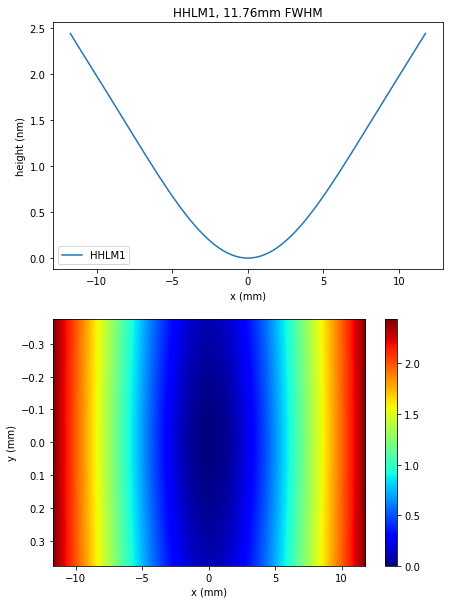

In [7]:
crystal_powers = np.array([30.8657, 0.2617, 2.9498, 0.1011, 0.1322, 0.0895])*0.1    # crytal power for 2DCM-111-220

crystal_powers *= np.array([1,0,0,0,0,0])

# directories
dir_profile = '../DXS_Xtals_FEA4WFS/{}/'.format(HHLM_type)

# holders
shapeErrors = [None for i in range(n_crys)]
x_mirs      = [None for i in range(n_crys)]
y_mirs      = [None for i in range(n_crys)]

if HHLM_type == 'Zigzag':
    crystal_profile_powers = np.array([
        [73.15, 16.53, 0.029, 0.027, 0.026, 0.03],
        [73.15, 16.79, 0.015, 0.015, 0.014, 0.013],
        [4.51, 50.1, 1.78, 1.69, 1.61, 1.88]
    ])
elif HHLM_type == '2DCM':
    crystal_profile_powers = np.array([
        [73.15, 0.027, 16.53, 0.029, 0.026, 0.03],
        [73.15, 0.015, 16.79, 0.015, 0.014, 0.013],
        [4.51, 1.69, 50.1, 1.78, 1.61, 1.88]
    ])

# choose shapeError profiles with the closest power
ratio_power = crystal_profile_powers/np.stack([crystal_powers for i in range(3)])
ratio_power[ratio_power<1] = 1/(ratio_power[ratio_power<1])
options = ratio_power.argmin(axis=0)+1

# load
for i, crystal in enumerate(crystals):
    if crystal_powers[i] == 0: continue
    # load profiles from file
    dy, xx, zz = load_crystal_data(dir_profile, crystal, options[i])
    # proportionality constant due to power and crystal dimension
    height_factor1 = crystal_powers[i] / crystal_profile_powers[options[i]-1, i]    
    height_factor2 = (l_crystal[i]*1e3/(xx.max()-xx.min()))*(w_crystal[i]*1e3/(zz.max()-zz.min()))
    shapeErrors[i] = dy*1e6 * height_factor1 / height_factor2    # [nm]
    x_mirs[i] = np.linspace(-l_crystal[i]/2, l_crystal[i]/2, xx.shape[0])
    y_mirs[i] = np.linspace(-w_crystal[i]/2, w_crystal[i]/2, xx.shape[1])
    
# plot
n_subplot = np.sum(crystal_powers!=0)
plt.figure(figsize=(n_subplot*5+2, 10))
for i in range(n_crys):
    if crystal_powers[i] == 0: continue
    plt.subplot(2, n_subplot, int(i+1))
    plt.plot(x_mirs[i]*1e3, shapeErrors[i][1024,:], label=crystals[i])
    plt.legend(); plt.xlabel('x (mm)'); plt.ylabel('height (nm)')
    plt.title('{}, {}mm FWHM'.format(crystals[i], round(l_crystal[i]/2*1e3,2)))
    
    plt.subplot(2, n_subplot, int(i+n_subplot+1))
    plt.imshow(shapeErrors[i], cmap='jet',
              extent = [x_mirs[i].min()*1e3, x_mirs[i].max()*1e3, y_mirs[i].max()*1e3, y_mirs[i].min()*1e3])
    plt.colorbar(); plt.xlabel('x (mm)'); plt.ylabel('y (mm)'); plt.axis('tight')


# Scanning m2_q

In [8]:
%%capture capt
n_loop = 31
log_m2_q = np.linspace(2, 5, n_loop)
m2_q = 10**log_m2_q
# m2_q = np.linspace(-100, 10000, n_loop)
pulse_duration = np.zeros(n_loop)
pulse_tilt = np.zeros(n_loop)
spatial_chirp = np.zeros(n_loop)
energy_bandwidth = np.zeros(n_loop)
throughput = np.zeros(n_loop)

failed_run = []
if os.path.exists(dir_plot+'perfect_{}um_slit.h5'.format(slit_width*1e6)):
    print('perfect case already simulated, skipping to plots')
else:
    for i in range(n_loop):
        mono_devices, mono_beamline = define_beamline_normal(E0,
                                   m1_p=m1_p, m2_q=m2_q[i], HHLM_type=HHLM_type,
                                   slit_width=slit_width, f1=f1, f2=f2,
                                   hkl1=hkl1, alphaAsym1=alphaAsym1,
                                   hkl2=hkl2, alphaAsym2=alphaAsym2,
                                   hkl3=hkl3, alphaAsym3=alphaAsym3,
                                   shapeErrors=[None for i in range(6)],
                                   l_crystal=l_crystal,
                                   w_crystal=w_crystal)

        screen_names = ['im_input','im_out']

        beam_params['photonEnergy'] = E0
        pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=100)
        pulse.propagate(beamline=mono_beamline,screen_names=screen_names)
        try:
            c, pulse_duration[i] = pulse.pulse_duration('im_out')
            pulse_tilt[i] = pulse.pulsefront_tilt('im_out')
            spatial_chirp[i] = pulse.spatial_chirp('im_out')
            energy_bandwidth[i] = pulse.pulse_bandwidth('im_out')
            throughput[i] = pulse.throughput('im_input','im_out')
        except:
            failed_run.append(i)

    with h5py.File(dir_plot+'perfect_{}um_slit.h5'.format(slit_width*1e6), 'w') as f:
        f.create_dataset('m2_q', data=m2_q)
        f.create_dataset('pulse_duration', data=pulse_duration)
        f.create_dataset('tilt', data=pulse_tilt)
        f.create_dataset('chirp', data=spatial_chirp)
        f.create_dataset('bandwidth', data=energy_bandwidth)
        f.create_dataset('throughput', data=throughput)

winsound.Beep(1500, 1000)

In [9]:
print(failed_run)

[]


output/17795eV/m2_q_optimization/2DCM_111_220/0.0_0.0_deg_20.0mm_offset/


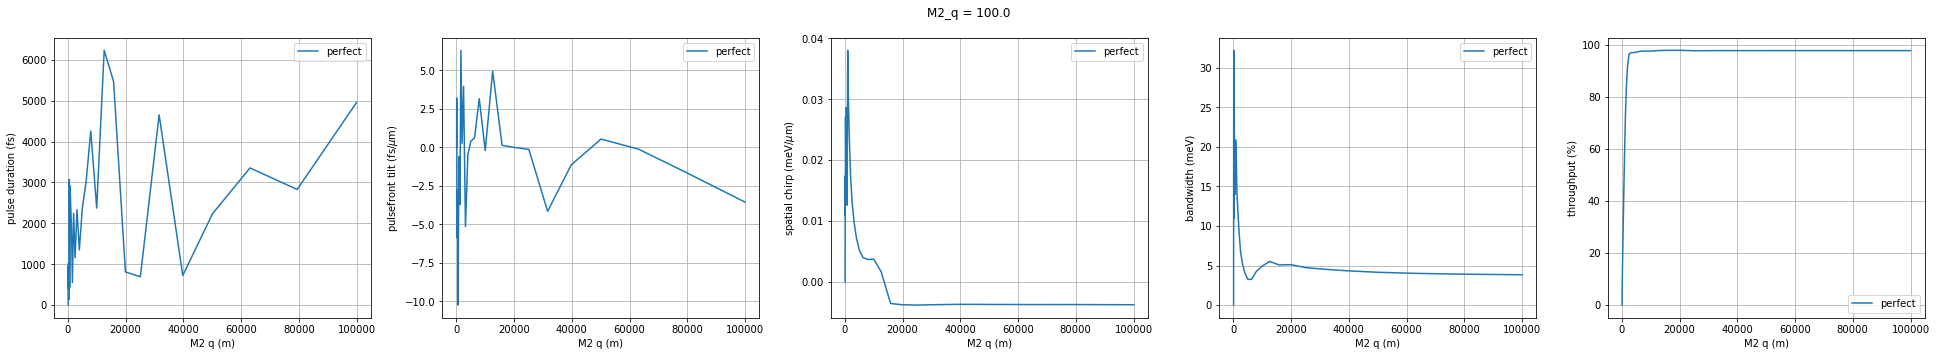

In [10]:
##### m2_p optimization (perfect case)
with h5py.File(dir_plot+'perfect_{}um_slit.h5'.format(slit_width*1e6), 'r') as f:
    m2_q = f['m2_q'][:]
    pulse_duration0 = f['pulse_duration'][:]
    pulse_tilt0 = f['tilt'][:]
    spatial_chirp0 = f['chirp'][:]
    energy_bandwidth0 = f['bandwidth'][:]
    throughput0 = f['throughput'][:]

print(dir_plot)
try:
    result = find_zero(m2_q, spatial_chirp0, x_i=5e3, x_f=1.5e4, direction='decrease')
except:
    result = m2_q[energy_bandwidth0.argmin()]

plt.figure(figsize=(27,5))
plt.suptitle('M2_q = {}'.format(result))

plt.subplot(1,5,1)
plt.plot(m2_q, pulse_duration0,label='perfect')
plt.xlabel('M2 q (m)')
plt.ylabel('pulse duration (fs)')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.ylim([0, 2e3])

plt.subplot(1,5,2)
plt.plot(m2_q, pulse_tilt0,label='perfect')
plt.xlabel('M2 q (m)')
plt.ylabel(r'pulsefront tilt (fs/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.subplot(1,5,3)
plt.plot(m2_q, spatial_chirp0*1000,label='perfect')
plt.xlabel('M2 q (m)')
plt.ylabel(r'spatial chirp (meV/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.ylim([-5e-3, 5e-3])

plt.subplot(1,5,4)
plt.plot(m2_q, energy_bandwidth0*1000,label='perfect')
plt.xlabel('M2 q (m)')
plt.ylabel('bandwidth (meV)')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.ylim([0, 50])

plt.subplot(1,5,5)
plt.plot(m2_q, throughput0*100,label='perfect')
plt.xlabel('M2 q (m)')
plt.ylabel('throughput (%)')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.ylim([0, 40])

plt.savefig(dir_plot+'M2_p_optimization.png')

### with shapeError, if converging mir 2

In [14]:
%%capture capt

n_loop = 31
log_m2_q1 = np.linspace(np.log10(1e4), np.log10(1e7), n_loop)
m2_q1 = 10**log_m2_q1
# m2_q1 = np.linspace(-150, -50, n_loop)
pulse_duration1 = np.zeros_like(m2_q1)
pulse_tilt1 = np.zeros_like(m2_q1)
spatial_chirp1 = np.zeros_like(m2_q1)
energy_bandwidth1 = np.zeros_like(m2_q1)
throughput1 = np.zeros_like(m2_q1)

# get file name based on crystal powers
for i in range(n_crys):
    if i == 0:
        fname_error = ''
    if crystal_powers[i] != 0:
        fname_error += '{}_{}W_conv_'.format(crystals[i], round(crystal_powers[i],3))
print(fname_error)

# loop
fails = []
for i in range(n_loop):
    mono_devices, mono_beamline = define_beamline_normal(E0,
                               m1_p=m1_p, m2_q=m2_q1[i], HHLM_type=HHLM_type,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)
    
    screen_names = ['im_input','im_out']

    beam_params['photonEnergy'] = E0
    try:
        pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=100)
        pulse.propagate(beamline=mono_beamline,screen_names=screen_names)
    except:
        fails.append([i])

    try:
        c, pulse_duration1[i] = pulse.pulse_duration('im_out')
        pulse_tilt1[i] = pulse.pulsefront_tilt('im_out')
        spatial_chirp1[i] = pulse.spatial_chirp('im_out')
        energy_bandwidth1[i] = pulse.pulse_bandwidth('im_out')
        throughput1[i] = pulse.throughput('im_input','im_out')
    except:
        pulse_duration1[i] = 1e30
        pulse_tilt1[i] = 1e30
        spatial_chirp1[i] = 1e30
        energy_bandwidth1[i] = 1e30
        throughput1[i] = 0.0

with h5py.File(dir_plot+fname_error+'.h5', 'w') as f:
    f.create_dataset('m2_q', data=m2_q1)
    f.create_dataset('pulse_duration', data=pulse_duration1)
    f.create_dataset('tilt', data=pulse_tilt1)
    f.create_dataset('chirp', data=spatial_chirp1)
    f.create_dataset('bandwidth', data=energy_bandwidth1)
    f.create_dataset('throughput', data=throughput1)

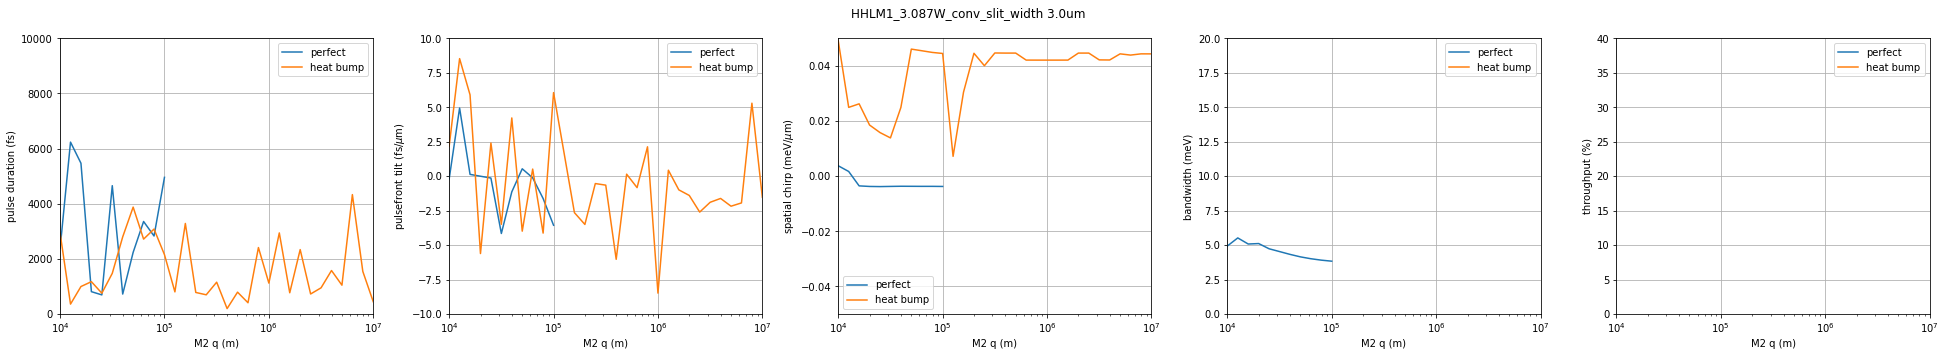

In [17]:
##### with shapeErrors

with h5py.File(dir_plot+fname_error+'.h5', 'r') as f:
    p1 = f['m2_q'][:]
    pulse_duration1 = f['pulse_duration'][:]
    pulse_tilt1 = f['tilt'][:]
    spatial_chirp1 = f['chirp'][:]
    energy_bandwidth1 = f['bandwidth'][:]
    throughput1 = f['throughput'][:]

##### get new m2_q
def find_zero(x, y, direction=None, x_i=0, x_f=1e5):
    y = y[np.intersect1d(np.where(x>=x_i), np.where(x<=x_f))]
    x = x[np.intersect1d(np.where(x>=x_i), np.where(x<=x_f))]

    # if linearly decrease:
    if np.median(y[:5]) >= np.median(y[-5:]):
        indices = np.where(y>=0)[0]
    else:
        indices = np.where(y<=0)[0]
    if direction == 'increase':
        indices = np.where(y<=0)[0]
    elif direction == 'decrease':
        indices = np.where(y>=0)[0]
    index = indices[-1]

    slope = (y[index+1] - y[index])/(x[index+1] - x[index])
    result = x[index] - y[index]/slope
    print('left {}, right {}, result {}'.format(x[index], x[index+1], result))
    return result

try:
    result = find_zero(m2_q1, spatial_chirp1, direction='decrease')
    sup_title = fname_error+'_M2_p={}, slit_width {}um'.format(result, slit_width*1e6)
    print('m2_q optimized', result)
except:
    result = m2_q1[energy_bandwidth1.argmin()]
    sup_title = fname_error+'slit_width {}um'.format(slit_width*1e6)

x_min = np.min(m2_q1); x_max = np.max([m2_q1, m2_q])
    
scale = 'log'
#### plot
plt.figure(figsize=(27,5))
plt.suptitle(sup_title)

# duration
plt.subplot(1,5,1)
plt.plot(m2_q, pulse_duration0, label='perfect')
plt.plot(m2_q1, pulse_duration1, label='heat bump')
plt.xlabel('M2 q (m)'); plt.ylabel('pulse duration (fs)')
plt.grid(); plt.legend(); plt.tight_layout()
plt.xlim([x_min, x_max]); plt.ylim([0, 1e4])
plt.xscale(scale)

# tilt
plt.subplot(1,5,2)
plt.plot(m2_q, pulse_tilt0, label='perfect')
plt.plot(m2_q1, pulse_tilt1, label='heat bump')
plt.xlabel('M2 q (m)'); plt.ylabel(r'pulsefront tilt (fs/$\mu$m)')
plt.grid(); plt.legend(); plt.tight_layout()
plt.xlim([x_min, x_max]); plt.ylim([-10, 10])
plt.xscale(scale)

# chirp
plt.subplot(1,5,3)
plt.plot(m2_q, spatial_chirp0*1000, label='perfect')
plt.plot(m2_q1, spatial_chirp1*1000, label='heat bump')
plt.xlabel('M2 q (m)'); plt.ylabel(r'spatial chirp (meV/$\mu$m)')
plt.grid(); plt.legend(); plt.tight_layout()
plt.xlim([x_min, x_max]); plt.ylim([-5e-2, 5e-2])
plt.xscale(scale)

# bandwidth
plt.subplot(1,5,4)
plt.plot(m2_q, energy_bandwidth0*1000, label='perfect')
plt.plot(m2_q1, energy_bandwidth1*1000, label='heat bump')
plt.xlabel('M2 q (m)'); plt.ylabel('bandwidth (meV)')
plt.grid(); plt.legend(); plt.tight_layout()
plt.xlim([x_min, x_max]); plt.ylim([0, 20])
plt.xscale(scale)

# throughput
plt.subplot(1,5,5)
plt.plot(m2_q, throughput0*100, label='perfect')
plt.plot(m2_q1, throughput1*100, label='heat bump')
plt.xlabel('M2 q (m)'); plt.ylabel('throughput (%)')
plt.grid(); plt.legend(); plt.tight_layout()
plt.xlim([x_min, x_max]); plt.ylim([0, 40])
plt.xscale(scale)



plt.savefig(dir_plot+fname_error+'_correction.png')
# plt.close('all')


### with shapeError, if diverging mirror 2

In [26]:
%%capture capt

n_loop = 31
log_m2_q1 = np.linspace(np.log10(1e2), np.log10(1e5), n_loop)
m2_q1 = -10**log_m2_q1
# m2_q1 = np.linspace(-150, -50, n_loop)
pulse_duration1 = np.zeros_like(m2_q1)
pulse_tilt1 = np.zeros_like(m2_q1)
spatial_chirp1 = np.zeros_like(m2_q1)
energy_bandwidth1 = np.zeros_like(m2_q1)
throughput1 = np.zeros_like(m2_q1)

# get file name based on crystal powers
for i in range(n_crys):
    if i == 0:
        fname_error = ''
    if crystal_powers[i] != 0:
        fname_error += '{}_{}W_div_'.format(crystals[i], round(crystal_powers[i],3))
print(fname_error)

# loop
fails = []
for i in range(n_loop):
    mono_devices, mono_beamline = define_beamline_normal(E0,
                               m1_p=m1_p, m2_q=m2_q1[i], HHLM_type=HHLM_type,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)
    
    screen_names = ['im_input','im_out']

    beam_params['photonEnergy'] = E0
    try:
        pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=100)
        pulse.propagate(beamline=mono_beamline,screen_names=screen_names)
    except:
        fails.append([i])

    try:
        c, pulse_duration1[i] = pulse.pulse_duration('im_out')
        pulse_tilt1[i] = pulse.pulsefront_tilt('im_out')
        spatial_chirp1[i] = pulse.spatial_chirp('im_out')
        energy_bandwidth1[i] = pulse.pulse_bandwidth('im_out')
        throughput1[i] = pulse.throughput('im_input','im_out')
    except:
        pulse_duration1[i] = 1e30
        pulse_tilt1[i] = 1e30
        spatial_chirp1[i] = 1e30
        energy_bandwidth1[i] = 1e30
        throughput1[i] = 0.0

with h5py.File(dir_plot+fname_error+'.h5', 'w') as f:
    f.create_dataset('m2_q', data=m2_q1)
    f.create_dataset('pulse_duration', data=pulse_duration1)
    f.create_dataset('tilt', data=pulse_tilt1)
    f.create_dataset('chirp', data=spatial_chirp1)
    f.create_dataset('bandwidth', data=energy_bandwidth1)
    f.create_dataset('throughput', data=throughput1)

left 63095.73444801943, right 79432.82347242821, result 70314.75055727235
m2_q optimized 70314.75055727235


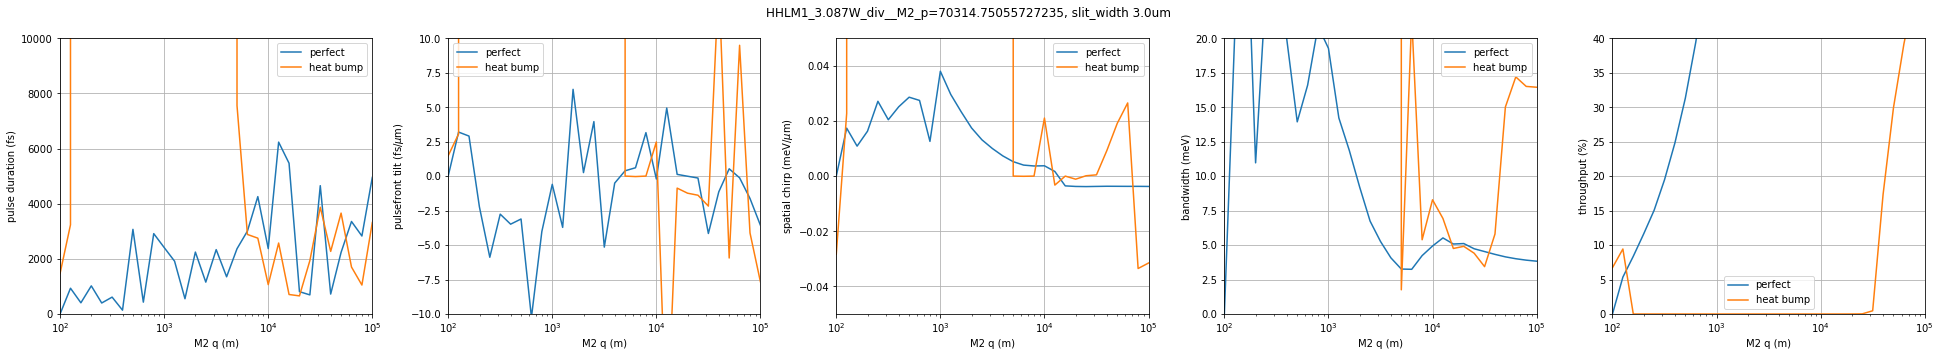

In [30]:
##### with shapeErrors

with h5py.File(dir_plot+fname_error+'.h5', 'r') as f:
    p1 = f['m2_q'][:]
    pulse_duration1 = f['pulse_duration'][:]
    pulse_tilt1 = f['tilt'][:]
    spatial_chirp1 = f['chirp'][:]
    energy_bandwidth1 = f['bandwidth'][:]
    throughput1 = f['throughput'][:]

m2_q1 = -m2_q1

##### get new m2_q
try:
    result = find_zero(m2_q1, spatial_chirp1, direction='decrease')
    sup_title = fname_error+'_M2_p={}, slit_width {}um'.format(result, slit_width*1e6)
    print('m2_q optimized', result)
except:
    result = m2_q1[energy_bandwidth1.argmin()]
    sup_title = fname_error+'slit_width {}um'.format(slit_width*1e6)


x_min = np.min([m2_q, m2_q1]); x_max = np.max([m2_q1, m2_q])

scale = 'log'
#### plot
plt.figure(figsize=(27,5))
plt.suptitle(sup_title)

# duration
plt.subplot(1,5,1)
plt.plot(m2_q, pulse_duration0, label='perfect')
plt.plot(m2_q1, pulse_duration1, label='heat bump')
plt.xlabel('M2 q (m)'); plt.ylabel('pulse duration (fs)')
plt.grid(); plt.legend(); plt.tight_layout()
plt.xlim([x_min, x_max]); plt.ylim([0, 1e4])
plt.xscale(scale)

# tilt
plt.subplot(1,5,2)
plt.plot(m2_q, pulse_tilt0, label='perfect')
plt.plot(m2_q1, pulse_tilt1, label='heat bump')
plt.xlabel('M2 q (m)'); plt.ylabel(r'pulsefront tilt (fs/$\mu$m)')
plt.grid(); plt.legend(); plt.tight_layout()
plt.xlim([x_min, x_max]); plt.ylim([-10, 10])
plt.xscale(scale)

# chirp
plt.subplot(1,5,3)
plt.plot(m2_q, spatial_chirp0*1000, label='perfect')
plt.plot(m2_q1, spatial_chirp1*1000, label='heat bump')
plt.xlabel('M2 q (m)'); plt.ylabel(r'spatial chirp (meV/$\mu$m)')
plt.grid(); plt.legend(); plt.tight_layout()
plt.xlim([x_min, x_max]); plt.ylim([-5e-2, 5e-2])
plt.xscale(scale)

# bandwidth
plt.subplot(1,5,4)
plt.plot(m2_q, energy_bandwidth0*1000, label='perfect')
plt.plot(m2_q1, energy_bandwidth1*1000, label='heat bump')
plt.xlabel('M2 q (m)'); plt.ylabel('bandwidth (meV)')
plt.grid(); plt.legend(); plt.tight_layout()
plt.xlim([x_min, x_max]); plt.ylim([0, 20])
plt.xscale(scale)

# throughput
plt.subplot(1,5,5)
plt.plot(m2_q, throughput0*100, label='perfect')
plt.plot(m2_q1, throughput1*100, label='heat bump')
plt.xlabel('M2 q (m)'); plt.ylabel('throughput (%)')
plt.grid(); plt.legend(); plt.tight_layout()
plt.xlim([x_min, x_max]); plt.ylim([0, 40])
plt.xscale(scale)



plt.savefig(dir_plot+fname_error+'_correction.png')
# plt.close('all')


In [32]:
# manually selecting the intersections
m2_q1[np.argsort(spatial_chirp1)]


array([ 79432.82347243, 100000.        ,    100.        ,  12589.25411794,
        19952.62314969,   6309.5734448 ,  15848.93192461,   7943.28234724,
         5011.87233627,  25118.8643151 ,  31622.77660168,  39810.71705535,
        50118.72336273,  10000.        ,    125.89254118,  63095.73444802,
          199.5262315 ,   3981.07170553,   2511.88643151,   1995.26231497,
         1584.89319246,   1258.92541179,   1000.        ,    794.32823472,
          630.95734448,    501.18723363,    398.10717055,    316.22776602,
          251.18864315,    158.48931925,   3162.27766017])

In [28]:
import winsound
winsound.Beep(1500, 3000)